<a href="https://colab.research.google.com/github/Felipe-Moreira-Sa/future_comparation/blob/main/future_look.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
!pip install yfinance

In [33]:
import yfinance as yf
from datetime import datetime, timedelta
import numpy as np


# Definir o ticker da Petrobras
ticker = 'PETR4.SA'  # Ticker da Petrobras na B3

# Calcular as datas para o download dos dados
data_final = datetime.now() - timedelta(days=130)
data_inicial = data_final - timedelta(days=5*365)

# Baixar os dados
df = yf.download(ticker, start=data_inicial, end=data_final)


[*********************100%%**********************]  1 of 1 completed


# Preparação dos Dados

In [34]:
from sklearn.preprocessing import StandardScaler

# Normalização dos dados
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[['Close']])

# Divisão em treino e teste
train_size = int(len(df_scaled) * 0.8)
train, test = df_scaled[0:train_size], df_scaled[train_size:len(df_scaled)]

def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 90
X_train, Y_train = create_dataset(train, time_step)
X_test, Y_test = create_dataset(test, time_step)
print(len(Y_test))

157


# Treinamento dos Modelos

# LSTM

In [35]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Remodelar entrada para LSTM
X_train_lstm = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_lstm = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Construir o modelo LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model_lstm.add(LSTM(50))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')
model_lstm.fit(X_train_lstm, Y_train, epochs=50, batch_size=32, verbose=2)


Epoch 1/50
29/29 - 4s - loss: 0.4075 - 4s/epoch - 141ms/step
Epoch 2/50
29/29 - 1s - loss: 0.1381 - 1s/epoch - 45ms/step
Epoch 3/50
29/29 - 2s - loss: 0.1010 - 2s/epoch - 82ms/step
Epoch 4/50
29/29 - 5s - loss: 0.0906 - 5s/epoch - 162ms/step
Epoch 5/50
29/29 - 2s - loss: 0.0792 - 2s/epoch - 84ms/step
Epoch 6/50
29/29 - 3s - loss: 0.0692 - 3s/epoch - 89ms/step
Epoch 7/50
29/29 - 2s - loss: 0.0665 - 2s/epoch - 79ms/step
Epoch 8/50
29/29 - 3s - loss: 0.0625 - 3s/epoch - 102ms/step
Epoch 9/50
29/29 - 3s - loss: 0.0602 - 3s/epoch - 94ms/step
Epoch 10/50
29/29 - 3s - loss: 0.0545 - 3s/epoch - 91ms/step
Epoch 11/50
29/29 - 3s - loss: 0.0531 - 3s/epoch - 93ms/step
Epoch 12/50
29/29 - 2s - loss: 0.0537 - 2s/epoch - 54ms/step
Epoch 13/50
29/29 - 1s - loss: 0.0481 - 1s/epoch - 46ms/step
Epoch 14/50
29/29 - 2s - loss: 0.0500 - 2s/epoch - 63ms/step
Epoch 15/50
29/29 - 1s - loss: 0.0488 - 1s/epoch - 47ms/step
Epoch 16/50
29/29 - 1s - loss: 0.0433 - 1s/epoch - 47ms/step
Epoch 17/50
29/29 - 1s - loss:

# GLM

In [36]:
from sklearn.linear_model import LinearRegression

model_glm = LinearRegression()
model_glm.fit(X_train, Y_train)


LinearRegression()

# Random Forest

In [37]:
from sklearn.ensemble import RandomForestRegressor

model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, Y_train)


RandomForestRegressor(random_state=42)

# Função de Previsão

# Baixar os Dados dos Últimos 90 Dias

In [38]:
import yfinance as yf
from datetime import datetime, timedelta

# Definir o ticker da ação desejada
ticker = 'PETR4.SA'  # Substitua 'AAPL' pelo ticker da ação desejada

# Calcular as datas para os últimos 90 dias
data_final_teste = datetime.now()
data_inicial_teste = data_final_teste - timedelta(days=130)

# Baixar os dados dos últimos 90 dias
df_teste = yf.download(ticker, start=data_inicial_teste.strftime('%Y-%m-%d'), end=data_final_teste.strftime('%Y-%m-%d'))

# Preparar os dados de teste sem aplicar o scaler
dados_reais = df_teste['Close'].values
print(len(dados_reais))


[*********************100%%**********************]  1 of 1 completed
90


#LSTM

In [39]:
def prever_proximos_90_dias_lstm(modelo_lstm, ultimos_dados, scaler):
    # Verifique o tamanho do dado de entrada e ajuste-o se necessário
    if ultimos_dados.shape[0] > 90:
        ultimos_dados = ultimos_dados[-90:]

    # Remodelar os dados para o formato esperado pelo modelo LSTM
    X_input = ultimos_dados.reshape(1, -1, 1)
    predictions = []

    for _ in range(90):
        # Prever o próximo ponto
        next_point = modelo_lstm.predict(X_input)
        predictions.append(next_point[0, 0])

        # Atualizar os dados de entrada com a previsão mais recente
        # Garantir que next_point tenha a dimensão correta para concatenação
        next_point_reshaped = next_point.reshape(1, 1, -1)
        X_input = np.append(X_input[:, 1:, :], next_point_reshaped, axis=1)

    # Inverter a normalização, se necessário
    predicted_values = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    return predicted_values


In [40]:
print(len(Y_test))
previsao_lstm = prever_proximos_90_dias_lstm(model_lstm, Y_test, scaler)

157
1/1 [==============================] - 0s 130ms/step


# Grafico LSTM

In [41]:
import matplotlib.pyplot as plt

def plot_comparacao_lstm(dados_reais, previsao_lstm, titulo='Comparação LSTM com Dados Reais'):
    plt.figure(figsize=(10, 5))
    plt.plot(dados_reais, label='Dados Reais', color='black')
    plt.plot(previsao_lstm, label='Previsão LSTM', color='blue')
    plt.title(titulo)
    plt.xlabel('Dias')
    plt.ylabel('Valor')
    plt.legend()
    plt.show()

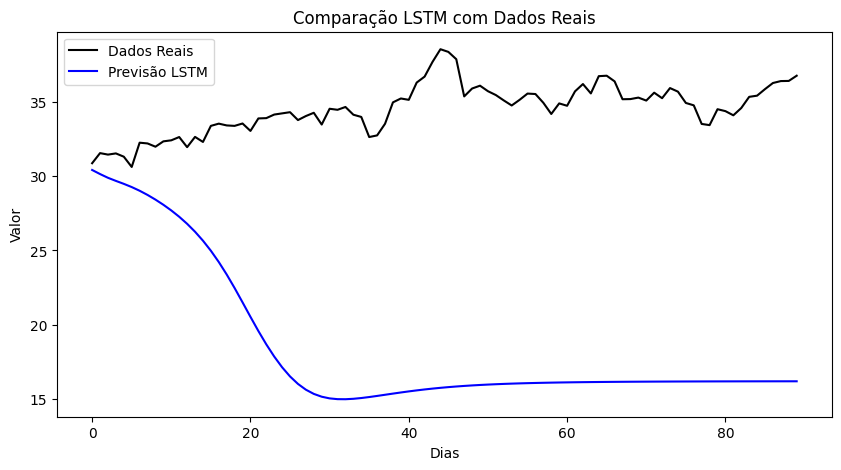

In [42]:
plot_comparacao_lstm(dados_reais, previsao_lstm)

# GLM

In [43]:
def prever_proximos_90_dias_glm(modelo_glm, ultimos_dados, scaler):
    predictions = []
    X_input = ultimos_dados

    for _ in range(90):
        # Prever o próximo ponto
        if len(X_input) > 90:
            X_input = X_input[-90:]  # Usar apenas os últimos 90 pontos
        next_point = modelo_glm.predict([X_input])[0]
        predictions.append(next_point)

        # Atualizar os dados de entrada com a previsão mais recente
        X_input = np.append(X_input, next_point)

    # Inverter a normalização, se necessário
    predicted_values = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    return predicted_values


In [44]:
previsao_glm = prever_proximos_90_dias_glm(model_glm, Y_test, scaler)

In [45]:
def plot_comparacao_glm(dados_reais, previsao_glm, titulo='Comparação GLM com Dados Reais'):
    plt.figure(figsize=(10, 5))
    plt.plot(dados_reais, label='Dados Reais', color='black')
    plt.plot(previsao_glm, label='Previsão GLM', color='red')
    plt.title(titulo)
    plt.xlabel('Dias')
    plt.ylabel('Valor')
    plt.legend()
    plt.show()

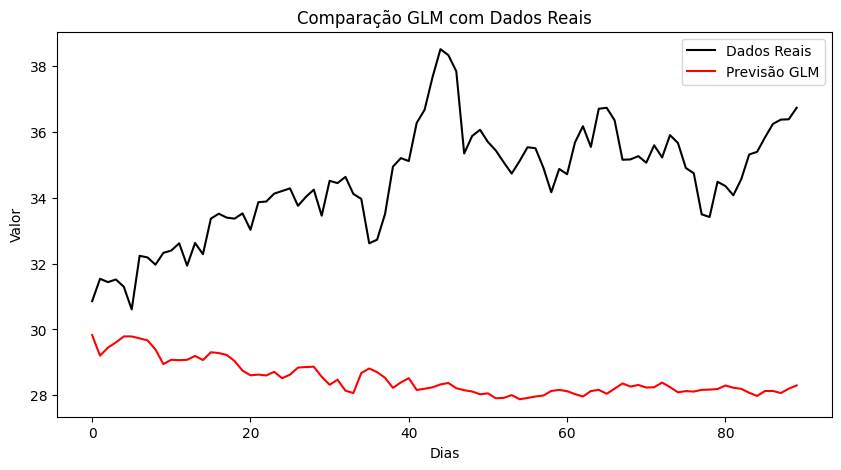

In [46]:
plot_comparacao_glm(dados_reais, previsao_glm)

# Random Forest

In [47]:
def prever_proximos_90_dias_random_forest(modelo_rf, ultimos_dados, scaler):
    predictions = []
    X_input = ultimos_dados

    for _ in range(90):
        # Prever o próximo ponto
        if len(X_input) > 90:
            X_input = X_input[-90:]  # Usar apenas os últimos 90 pontos
        next_point = modelo_rf.predict([X_input])[0]
        predictions.append(next_point)

        # Atualizar os dados de entrada com a previsão mais recente
        X_input = np.append(X_input, next_point)

    # Inverter a normalização, se necessário
    predicted_values = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    return predicted_values

In [48]:
previsao_rf = prever_proximos_90_dias_random_forest(model_rf, Y_test, scaler)

In [49]:
def plot_comparacao_rf(dados_reais, previsao_rf, titulo='Comparação Random Forest com Dados Reais'):
    plt.figure(figsize=(10, 5))
    plt.plot(dados_reais, label='Dados Reais', color='black')
    plt.plot(previsao_rf, label='Previsão RF', color='green')
    plt.title(titulo)
    plt.xlabel('Dias')
    plt.ylabel('Valor')
    plt.legend()
    plt.show()


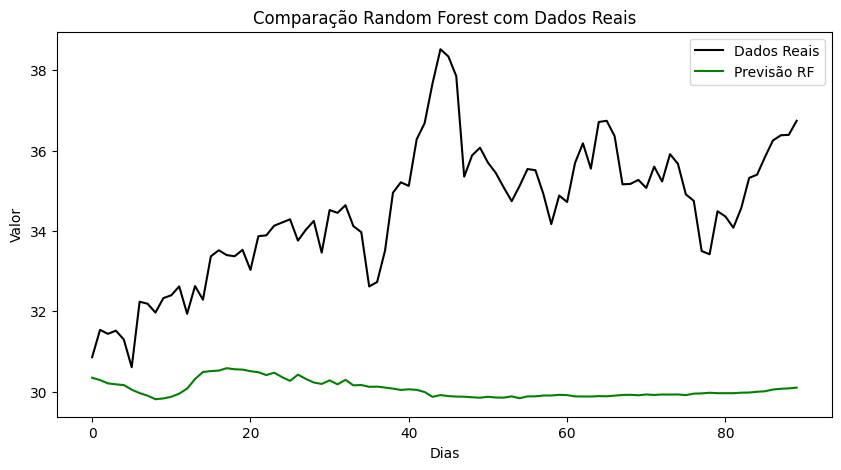

In [50]:
plot_comparacao_rf(dados_reais, previsao_rf)

# Avaliação e Comparação

# Comparação com gráficos

In [51]:
import matplotlib.pyplot as plt
def plot_previsoes(dados_reais, previsao_lstm, previsao_glm, previsao_rf):
    dias = range(len(dados_reais))

    plt.figure(figsize=(12, 6))
    plt.plot(dias, dados_reais, label='Dados Reais', color='black')
    plt.plot(dias, previsao_lstm, label='LSTM', color='blue')
    plt.plot(dias, previsao_glm, label='GLM', color='red')
    plt.plot(dias, previsao_rf, label='Random Forest', color='green')

    plt.title('Comparação de Previsões de Preço de Ações')
    plt.xlabel('Dias')
    plt.ylabel('Preço das Ações')
    plt.legend()
    plt.show()


# Grafico plotado com previsões vs dados reais

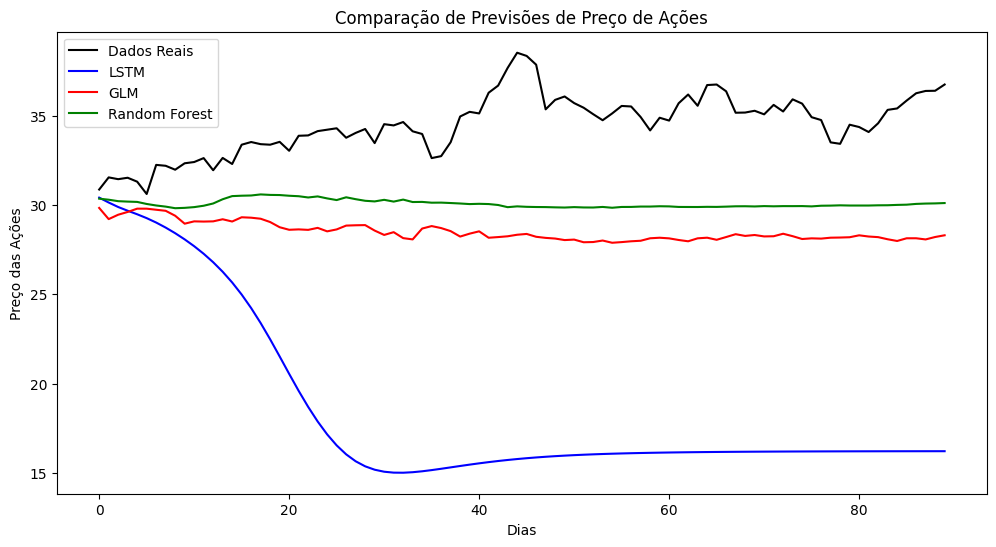

In [52]:
plot_previsoes(dados_reais, previsao_lstm, previsao_glm, previsao_rf)

# Cálculo das Métricas

In [53]:
from sklearn.metrics import mean_squared_error, r2_score

# Exemplo de cálculo do RMSE
rmse = sqrt(mean_squared_error(y_real, y_previsto))

# Exemplo de cálculo do R²
r2 = r2_score(y_real, y_previsto)

# Adicione cálculos para MAPE e correlação conforme necessário

NameError: ignored

Modelo LSTM

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

print("Tamanho de X_train:", X_train.shape)
print("Tamanho de X_test:", X_test.shape)
# Remodelar entrada para ser [amostras, tempo, características]
X_train_lstm = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_lstm = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Construir o modelo LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model_lstm.add(LSTM(50))
model_lstm.add(Dense(1))

model_lstm.compile(loss='mean_squared_error', optimizer='adam')
model_lstm.fit(X_train_lstm, Y_train, epochs=50, batch_size=32, verbose=2)


# GLM

In [ ]:
from sklearn.linear_model import LinearRegression

# Construir e treinar o modelo GLM
model_glm = LinearRegression()
model_glm.fit(X_train, Y_train)


# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Construir e treinar o modelo Random Forest
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, Y_train)
